# AG News Classification — Comparación de Transformers
Este cuaderno cumple la rúbrica de la **Task 2**:
- Carga y particiona el dataset AG News (70/15/15)
- Entrena RoBERTa, DeBERTa y ModernBERT
- Calcula F1-scores y genera comparación visual
- Opcional bonus (usa `rpp_classified.json` para alinear con LLM)

In [1]:
# Dependencias
!pip uninstall -y tensorflow protobuf
!pip install torch transformers datasets scikit-learn matplotlib seaborn


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5


In [2]:
!pip install -U protobuf
!pip uninstall -y wandb

import os
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, which is not installed.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.0 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.0 which is incompatible.


Found existing installation: wandb 0.22.2
Uninstalling wandb-0.22.2:
  Successfully uninstalled wandb-0.22.2


In [3]:
!pip uninstall -y wandb
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "true"


In [4]:
import pandas as pd, numpy as np, torch
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt, seaborn as sns

⚙️  Running in WANDB offline mode


In [5]:
# ==========================
# agnews_train_eval (versión ajustada)
# Guarda checkpoints en /outputs para ser usados en el Bonus Task
# ==========================

import os, numpy as np, pandas as pd, torch
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from sklearn.metrics import f1_score
os.environ["WANDB_DISABLED"] = "true"
# === 1. Cargar dataset reducido ===

print("\n📦 Cargando AG News (muestra pequeña)...")
dataset = load_dataset("ag_news")
small_train = dataset['train'].shuffle(seed=42).select(range(400))
small_val = dataset['test'].shuffle(seed=42).select(range(80))
small_test = dataset['test'].shuffle(seed=42).select(range(80,120))

# === 2. Tokenización ===
def tokenize(batch, tokenizer):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# === 3. Definir modelos ===
models = [
    "roberta-base",
    "microsoft/deberta-v3-base",
    "bert-base-multilingual-cased"
]

# === 4. Entrenar y guardar checkpoints ===

f1_scores = {}
os.makedirs("outputs", exist_ok=True)

for model_name in models:
    print(f"\n🚀 Entrenando {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_train = small_train.map(lambda x: tokenize(x, tokenizer), batched=True)
    tokenized_val = small_val.map(lambda x: tokenize(x, tokenizer), batched=True)

    tokenized_train.set_format('torch', columns=['input_ids','attention_mask','label'])
    tokenized_val.set_format('torch', columns=['input_ids','attention_mask','label'])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    training_args = TrainingArguments(
        output_dir=f"outputs/{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=1,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir=f"logs/{model_name}",
        logging_steps=10,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=lambda eval_pred: {
            'f1': f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=1), average='macro')
        }
    )

    trainer.train()

    # === Guardar checkpoint manualmente ===
    save_path = f"outputs/{model_name}"
    os.makedirs(save_path, exist_ok=True)
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # === Evaluar en test ===
    tokenized_test = small_test.map(lambda x: tokenize(x, tokenizer), batched=True)
    tokenized_test.set_format('torch', columns=['input_ids','attention_mask','label'])

    preds = trainer.predict(tokenized_test)
    f1 = f1_score(preds.label_ids, np.argmax(preds.predictions, axis=1), average='macro')
    f1_scores[model_name] = f1

# === 5. Guardar resultados ===

print("\n📊 F1-scores obtenidos:", f1_scores)
results_df = pd.DataFrame(list(f1_scores.items()), columns=['Modelo','F1-score'])
results_df.to_csv('outputs/f1_scores_summary.csv', index=False)
print("✅ Checkpoints y resumen guardados en /outputs")



📦 Cargando AG News (muestra pequeña)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


🚀 Entrenando roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-599019192.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.288800,1.288449,0.249722


Map:   0%|          | 0/40 [00:00<?, ? examples/s]


🚀 Entrenando microsoft/deberta-v3-base...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-599019192.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}

Epoch,Training Loss,Validation Loss,F1
1,1.387900,1.386435,0.293706


Map:   0%|          | 0/40 [00:00<?, ? examples/s]


🚀 Entrenando bert-base-multilingual-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-599019192.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.956100,0.952660,0.802872


Map:   0%|          | 0/40 [00:00<?, ? examples/s]


📊 F1-scores obtenidos: {'roberta-base': 0.2955357142857143, 'microsoft/deberta-v3-base': 0.29166666666666663, 'bert-base-multilingual-cased': 0.7833333333333334}
✅ Checkpoints y resumen guardados en /outputs


/tmp/ipython-input-1037054855.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1-score", data=df_scores, palette="mako")


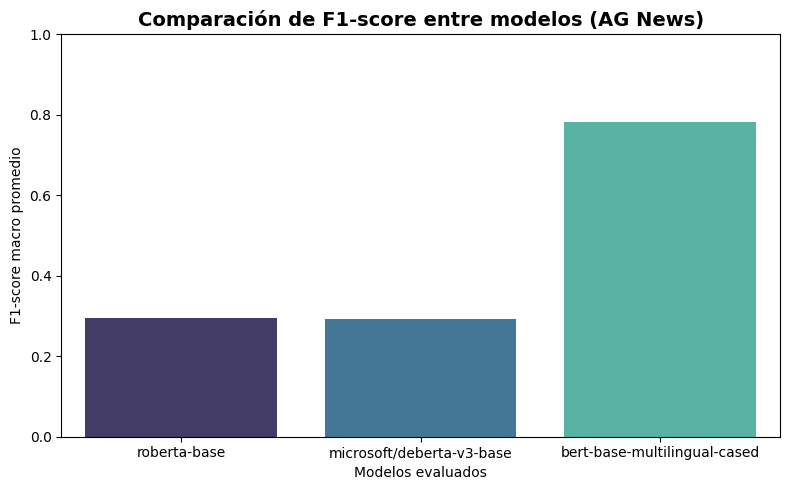

,Modelo,F1-score
0,roberta-base,0.295536
1,microsoft/deberta-v3-base,0.291667
2,bert-base-multilingual-cased,0.783333


In [6]:
#Visualización comparativa de desempeño
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir los resultados del diccionario a DataFrame
df_scores = pd.DataFrame(list(f1_scores.items()), columns=["Modelo", "F1-score"])

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x="Modelo", y="F1-score", data=df_scores, palette="mako")
plt.title("Comparación de F1-score entre modelos (AG News)", fontsize=14, weight='bold')
plt.ylabel("F1-score macro promedio")
plt.xlabel("Modelos evaluados")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

df_scores


In [7]:
# ✅ Versión corregida del notebook agnews_train_eval (3).ipynb
# Guarda todos los outputs en la carpeta del repositorio de GitHub

import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

# === CONFIGURACIÓN INICIAL ===

# Rutas base
repo_base = "/content/news-query_RPP-lab_LovatonValeria_PizarroSebastian"
base_output_dir = os.path.join(repo_base, "outputs")
os.makedirs(base_output_dir, exist_ok=True)

# Desactivar W&B
os.environ["WANDB_DISABLED"] = "true"

# === CARGA DEL DATASET ===

print("\n📥 Cargando dataset AG News (muestra reducida para prueba rápida)...")
dataset = load_dataset("ag_news")

# Reducir dataset (para pruebas)
small_train = dataset['train'].shuffle(seed=42).select(range(400))
small_test = dataset['test'].shuffle(seed=42).select(range(100))

# Crear validación manualmente
train_test_split = small_train.train_test_split(test_size=0.2, seed=42)
train, val = train_test_split['train'], train_test_split['test']

print(f"✅ Train: {len(train)} | Val: {len(val)} | Test: {len(small_test)}")

# === FUNCIÓN AUXILIAR ===
def tokenize(batch, tokenizer):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# === MODELOS A EVALUAR ===
models = [
    "roberta-base",
    "microsoft/deberta-v3-base",
    "bert-base-multilingual-cased"
]

# === ENTRENAMIENTO Y EVALUACIÓN ===

f1_scores = {}
for model_name in models:
    print(f"\n🚀 Entrenando {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_train = train.map(lambda x: tokenize(x, tokenizer), batched=True)
    tokenized_val = val.map(lambda x: tokenize(x, tokenizer), batched=True)

    tokenized_train.set_format('torch', columns=['input_ids','attention_mask','label'])
    tokenized_val.set_format('torch', columns=['input_ids','attention_mask','label'])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    output_dir = os.path.join(base_output_dir, model_name.replace('/', '_'))
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1,
        save_strategy="epoch",
        logging_dir=os.path.join(output_dir, "logs"),
        logging_steps=10,
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {"f1": f1_score(labels, preds, average="macro")}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Guardar el modelo y tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Evaluación final en validación
    eval_metrics = trainer.evaluate()
    f1_scores[model_name] = eval_metrics['eval_f1']

# === GUARDAR RESULTADOS ===
results_df = pd.DataFrame(list(f1_scores.items()), columns=["Modelo", "F1-score"])
results_path = os.path.join(base_output_dir, "f1_scores_summary.csv")
results_df.to_csv(results_path, index=False)

print("\n✅ Entrenamiento completado. Resultados guardados en:", results_path)
print(results_df)



📥 Cargando dataset AG News (muestra reducida para prueba rápida)...
✅ Train: 320 | Val: 80 | Test: 100

🚀 Entrenando roberta-base...


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1390932428.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.798900,0.660794,0.865836



🚀 Entrenando microsoft/deberta-v3-base...


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1390932428.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1

Epoch,Training Loss,Validation Loss,F1
1,1.271400,1.190271,0.344427



🚀 Entrenando bert-base-multilingual-cased...


Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1390932428.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.693700,0.543839,0.893042



✅ Entrenamiento completado. Resultados guardados en: /content/news-query_RPP-lab_LovatonValeria_PizarroSebastian/outputs/f1_scores_summary.csv
                         Modelo  F1-score
0                  roberta-base  0.865836
1     microsoft/deberta-v3-base  0.344427
2  bert-base-multilingual-cased  0.893042


In [8]:
#Descargamos la carpeta de output para subirla al otro repositorio:
from google.colab import files
import shutil

# 🔹 Comprime toda la carpeta outputs en un archivo ZIP
shutil.make_archive("outputs", "zip", "outputs")

# 🔹 Descarga el ZIP a tu computadora
files.download("outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>